In [33]:
import os
import rosbag
from sensor_msgs.msg import CompressedImage
from std_msgs.msg import Float32
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv('/home/user/persistent/subset_2019-07-15-10-59-32_extract/topics_combined.csv')
print(df.head())

image_paths = df['filename'].apply(lambda x: os.path.join('/home/user/persistent/subset_2019-07-15-10-59-32_extract/camera_images', x)).tolist()
speed_labels = df['sog'].tolist()

X_train, X_temp, y_train, y_temp = train_test_split(image_paths, speed_labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


           timestamp_x  height  width  \
0  1563177573045822770   500.0  530.0   
1  1563177573084979018   500.0  530.0   
2  1563177573102097009   500.0  530.0   
3  1563177573132062030   500.0  530.0   
4  1563177573164932616   500.0  530.0   

                                            filename  \
0  _camera_crop_image_rect_color_compressed_00000...   
1  _camera_crop_image_rect_color_compressed_00000...   
2  _camera_crop_image_rect_color_compressed_00000...   
3  _camera_crop_image_rect_color_compressed_00000...   
4  _camera_crop_image_rect_color_compressed_00000...   

                                            filepath          timestamp_y  \
0  camera_images/_camera_crop_image_rect_color_co...  1563177573126301065   
1  camera_images/_camera_crop_image_rect_color_co...  1563177573126301065   
2  camera_images/_camera_crop_image_rect_color_co...  1563177573126301065   
3  camera_images/_camera_crop_image_rect_color_co...  1563177573126301065   
4  camera_images/_camera_crop_i

In [34]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image as PILImage
import cv2  # Don't forget to import OpenCV

class SpeedDataset(Dataset):
    def __init__(self, image_paths, speeds, transform=None):
        self.image_paths = image_paths
        self.speeds = speeds
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            # Load image
            img_path = self.image_paths[idx]
            image = cv2.imread(img_path)
            if image is None:
                raise FileNotFoundError(f"Image not found: {img_path}")
            
            # Convert to RGB and apply transforms
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if self.transform:
                image = self.transform(PILImage.fromarray(image))
            
            # Get speed and ensure correct type
            speed = torch.tensor(self.speeds[idx], dtype=torch.float32)
            
            # Add sequence dimension
            return image.unsqueeze(0), speed  # Shape: (1, C, H, W)
        
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            return torch.zeros(1, 3, 224, 224), torch.tensor(0.0)



# Define the image transformations (resize, normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to (224, 224)
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Create the dataset and dataloaders
train_dataset = SpeedDataset(X_train, y_train, transform=transform)
val_dataset = SpeedDataset(X_val, y_val, transform=transform)
test_dataset = SpeedDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class simpleCNNLSTM(nn.Module):
    def __init__(self, device="cuda"):
        super().__init__()

        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(64)

        # LSTM layer
        self.lstm1 = nn.LSTM(input_size=64*14*14, hidden_size=256, num_layers=1, batch_first=True)

        # Fully connected layers with Dropout
        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.5)  # Dropout with 50% chance
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        if x.dim() == 5:
            x = x.squeeze(1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))

        batch_size, channels, height, width = x.size()
        x = x.view(batch_size, -1)  # Flatten the output for LSTM

        # LSTM
        x, _ = self.lstm1(x.unsqueeze(1))  # Add seq_len dimension
        x = x.contiguous().view(-1, 256)  # Reshape the output for FC layers

        # Fully connected layers with Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x.squeeze()


# Example of model instantiation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simple_model = simpleCNNLSTM(device=device)
print(simple_model)


simpleCNNLSTM(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm1): LSTM(12544, 256, batch_first=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and utilities
model1 = simpleCNNLSTM(device=device).to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
epochs = 10
best_val_loss = float('inf')

train_losses = []
val_losses = []

for epoch in range(epochs):
    # Training
    model1.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model1(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    # Validation
    model1.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            val_loss += loss_fn(model1(inputs), labels).item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')


Epoch 1/10 | Train Loss: 0.0026 | Val Loss: 0.0006
Epoch 2/10 | Train Loss: 0.0011 | Val Loss: 0.0004
Epoch 3/10 | Train Loss: 0.0011 | Val Loss: 0.0006
Epoch 4/10 | Train Loss: 0.0010 | Val Loss: 0.0003
Epoch 5/10 | Train Loss: 0.0008 | Val Loss: 0.0003
Epoch 6/10 | Train Loss: 0.0007 | Val Loss: 0.0002
Epoch 7/10 | Train Loss: 0.0006 | Val Loss: 0.0004
Epoch 8/10 | Train Loss: 0.0006 | Val Loss: 0.0002
Epoch 9/10 | Train Loss: 0.0006 | Val Loss: 0.0001
Epoch 10/10 | Train Loss: 0.0005 | Val Loss: 0.0001


/home/user/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/user/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 0.0018


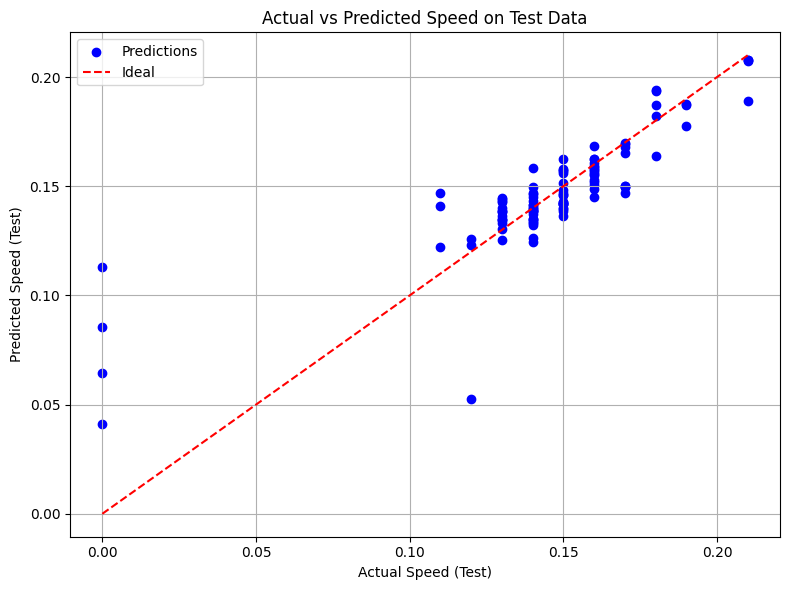

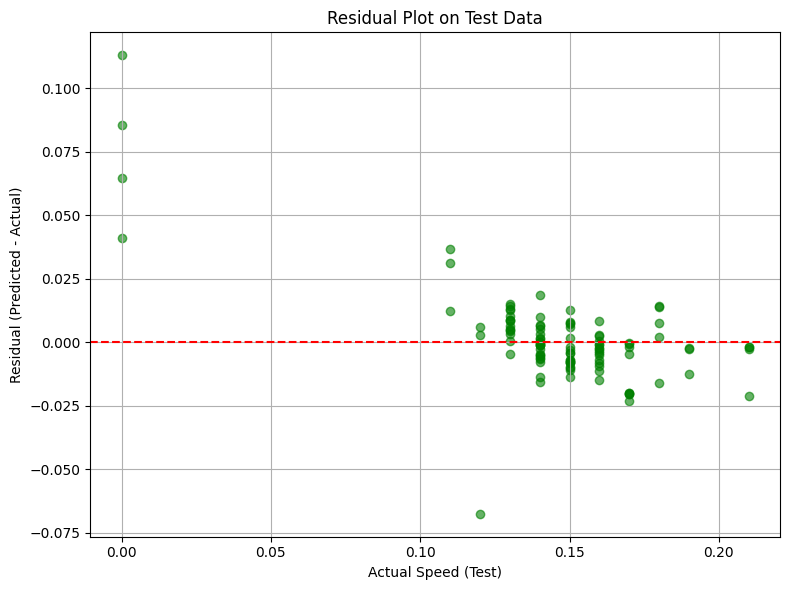

In [41]:
import torch
import torch.nn as nn

# Assuming you have your trained 'model' and 'test_loader' defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.eval()  # Set the model to evaluation mode
test_loss = 0.0
all_preds_test = []
all_labels_test = []

loss_fn = nn.MSELoss() # Or your chosen loss function

with torch.no_grad():  # Disable gradient calculations during testing
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model1(inputs)
        loss = loss_fn(outputs, labels.unsqueeze(1)) # Adjust label shape if needed

        test_loss += loss.item() * inputs.size(0)

        predictions = outputs.cpu().numpy()
        ground_truth = labels.cpu().numpy()

        all_preds_test.extend(predictions.flatten())
        all_labels_test.extend(ground_truth.flatten())

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

# Now you can use all_preds_test and all_labels_test for plotting
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot of predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(all_labels_test, all_preds_test, c='blue', label='Predictions')
plt.plot([min(all_labels_test), max(all_labels_test)], [min(all_labels_test), max(all_labels_test)], 'r--', label='Ideal')
plt.xlabel('Actual Speed (Test)')
plt.ylabel('Predicted Speed (Test)')
plt.title('Actual vs Predicted Speed on Test Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Residual plot
residuals_test = np.array(all_preds_test) - np.array(all_labels_test)
plt.figure(figsize=(8, 6))
plt.scatter(all_labels_test, residuals_test, c='green', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Speed (Test)')
plt.ylabel('Residual (Predicted - Actual)')
plt.title('Residual Plot on Test Data')
plt.grid(True)
plt.tight_layout()
plt.show()


In [69]:
import torch
import torch.nn as nn
import torchvision.models as models

class FineTunedCNNLSTM(nn.Module):
    def __init__(self,device= "cuda"):
        super().__init__()
        # Load pre-trained ResNet18
        self.resnet = models.resnet18(weights='IMAGENET1K_V1')
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 64)  # Reduce output features

        # LSTM
        self.lstm = nn.LSTM(input_size=64, hidden_size=128, batch_first=True)

        # Fully connected
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        batch_size, seq_len, c, h, w = x.shape
        features = []
        for t in range(seq_len):
            frame = x[:, t, :, :, :]  # (batch, 3, 64, 64)
            feat = self.resnet(frame)  # (batch, 64)
            features.append(feat)

        features = torch.stack(features, dim=1)  # (batch, seq_len, 64)

        output, _ = self.lstm(features)  # (batch, seq_len, 128)
        out = output[:, -1, :]  # Last time step
        out = self.fc(out)  # (batch, 1)
        return out.squeeze()

# Instantiate model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FineTunedCNNLSTM()
print(model)


FineTunedCNNLSTM(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and utilities
model2 = FineTunedCNNLSTM(device=device).to(device)
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()
epochs = 10
best_val_loss = float('inf')

train_losses = []
val_losses = []

for epoch in range(epochs):
    # Training
    model2.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model2(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    # Validation
    model2.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            val_loss += loss_fn(model2(inputs), labels).item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')


Epoch 1/10 | Train Loss: 0.0017 | Val Loss: 0.0003
Epoch 2/10 | Train Loss: 0.0004 | Val Loss: 0.0004
Epoch 3/10 | Train Loss: 0.0003 | Val Loss: 0.0001
Epoch 4/10 | Train Loss: 0.0003 | Val Loss: 0.0001
Epoch 5/10 | Train Loss: 0.0002 | Val Loss: 0.0002
Epoch 6/10 | Train Loss: 0.0002 | Val Loss: 0.0001
Epoch 7/10 | Train Loss: 0.0002 | Val Loss: 0.0002
Epoch 8/10 | Train Loss: 0.0002 | Val Loss: 0.0002
Epoch 9/10 | Train Loss: 0.0002 | Val Loss: 0.0001
Epoch 10/10 | Train Loss: 0.0002 | Val Loss: 0.0001


/home/user/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/user/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 0.0027


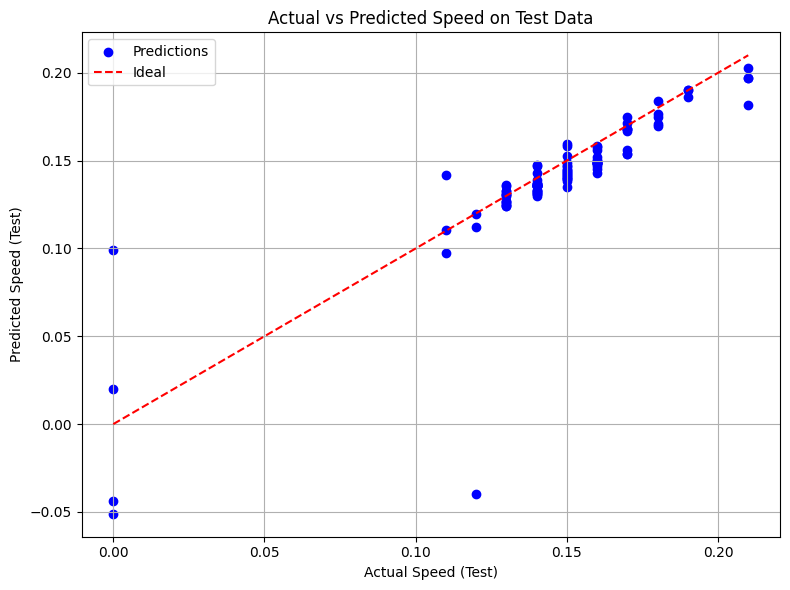

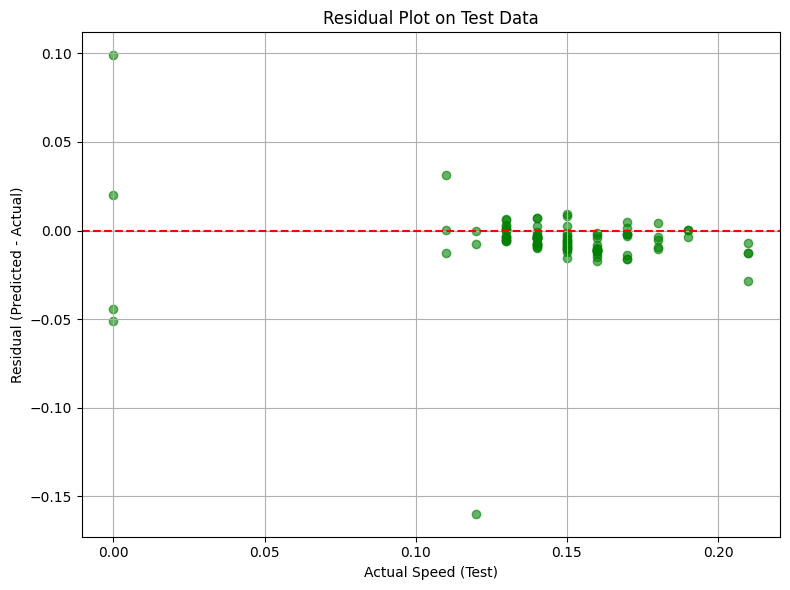

In [72]:
import torch
import torch.nn as nn

# Assuming you have your trained 'model' and 'test_loader' defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.eval()  # Set the model to evaluation mode
test_loss = 0.0
all_preds_test = []
all_labels_test = []

loss_fn = nn.MSELoss() # Or your chosen loss function

with torch.no_grad():  # Disable gradient calculations during testing
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model2(inputs)
        loss = loss_fn(outputs, labels.unsqueeze(1)) # Adjust label shape if needed

        test_loss += loss.item() * inputs.size(0)

        predictions = outputs.cpu().numpy()
        ground_truth = labels.cpu().numpy()

        all_preds_test.extend(predictions.flatten())
        all_labels_test.extend(ground_truth.flatten())

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

# Now you can use all_preds_test and all_labels_test for plotting
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot of predictions vs actual
plt.figure(figsize=(8, 6))
plt.scatter(all_labels_test, all_preds_test, c='blue', label='Predictions')
plt.plot([min(all_labels_test), max(all_labels_test)], [min(all_labels_test), max(all_labels_test)], 'r--', label='Ideal')
plt.xlabel('Actual Speed (Test)')
plt.ylabel('Predicted Speed (Test)')
plt.title('Actual vs Predicted Speed on Test Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Residual plot
residuals_test = np.array(all_preds_test) - np.array(all_labels_test)
plt.figure(figsize=(8, 6))
plt.scatter(all_labels_test, residuals_test, c='green', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Speed (Test)')
plt.ylabel('Residual (Predicted - Actual)')
plt.title('Residual Plot on Test Data')
plt.grid(True)
plt.tight_layout()
plt.show()
